# 第7章 现代卷积神经网络

## 7.1 深度卷积神经网络(AlexNet)

### 练习 7.1.1

试着增加迭代轮数。对比LeNet的结果有什么不同？为什么？

**解答：**

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

&emsp;&emsp;AlexNet模型

In [ ]:
AlexNet = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

batch_size = 128  # 设置batch_size
AlexNet_train_iter, AlexNet_test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)  # 加载数据

&emsp;&emsp;LeNet模型,在上一章节中LeNet模型所用的学习率为0.9，在本章习题中继续沿用0.9。学习率为0.01模型无法收敛。

In [ ]:
LeNet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 128  # 设置batch_size
LeNet_train_iter, LeNet_test_iter = d2l.load_data_fashion_mnist(batch_size)  # 加载数据

&emsp;&emsp;AlexNet和LeNet模型，迭代轮数均为10的情况：

loss 0.328, train acc 0.879, test acc 0.875
1676.4 examples/sec on cuda:0


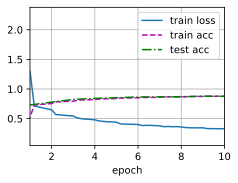

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, AlexNet_train_iter, AlexNet_test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.387, train acc 0.857, test acc 0.856
25277.9 examples/sec on cuda:0


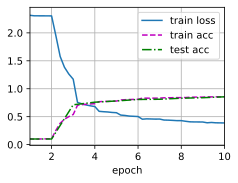

In [ ]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(LeNet, LeNet_train_iter, LeNet_test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;AlexNet和LeNet模型，迭代轮数均为20的情况：

loss 0.250, train acc 0.907, test acc 0.900
1669.0 examples/sec on cuda:0


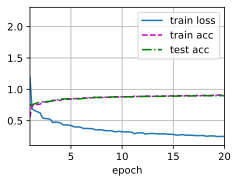

In [ ]:
lr, num_epochs = 0.01, 20
d2l.train_ch6(AlexNet, AlexNet_train_iter, AlexNet_test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.294, train acc 0.889, test acc 0.876
26778.7 examples/sec on cuda:0


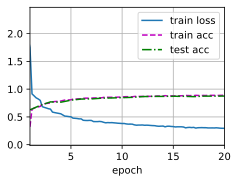

In [ ]:
lr, num_epochs = 0.9, 20
d2l.train_ch6(LeNet, LeNet_train_iter, LeNet_test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;AlexNet和LeNet模型，迭代轮数均为30的情况：

loss 0.203, train acc 0.924, test acc 0.912
1669.6 examples/sec on cuda:0


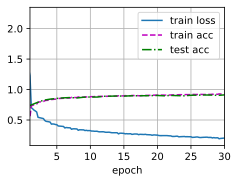

In [ ]:
lr, num_epochs = 0.01, 30
d2l.train_ch6(AlexNet, AlexNet_train_iter, AlexNet_test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.253, train acc 0.905, test acc 0.890
23879.9 examples/sec on cuda:0


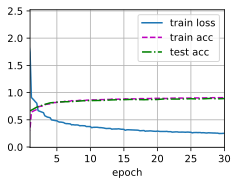

In [ ]:
lr, num_epochs = 0.9, 30
d2l.train_ch6(LeNet, LeNet_train_iter, LeNet_test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;以下是分别使用AlexNet模型和LeNet模型，在epoch为10，20，30情况下，train_acc和test_acc的精度。

|model|epochs|train_acc|test_acc|
|:-:|:-:|:-:|:-:|
|AlexNet|10|0.879|0.875|
|AlexNet|20|0.907|0.900|  
|AlexNet|30|0.924|0.912|
|LeNet|10|0.857|0.856|
|LeNet|20|0.889|0.876|  
|LeNet|30|0.905|0.890|

&emsp;&emsp;1. AlexNet整体上比LeNet有更高的训练和测试准确率,这说明AlexNet模型更加高效,有更强的拟合能力。

&emsp;&emsp;2. 随着epoch的增加,两种模型的训练准确率和测试准确率均有不同程度的提高,但AlexNet的提高速度更快,这再次说明AlexNet模型更强大。

&emsp;&emsp;3. AlexNet的训练准确率和测试准确率的差距较小,这说明AlexNet有更好的泛化能力,较少过拟合。而LeNet的差距较大,过拟合现象更严重。

&emsp;&emsp;4. AlexNet在30个epoch后,训练准确率继续提高but测试准确率趋于稳定,这表现出一定的过拟合。而LeNet两者的差距仍在扩大,过拟合更加严重。

&emsp;&emsp; 综上,AlexNet大约在20-30个epoch之间达到最佳效果,LeNet可能需要提前停止,在20个epoch左右。



### 练习 7.1.2

AlexNet对Fashion-MNIST数据集来说可能太复杂了。
1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
1. 设计一个更好的模型，可以直接在$28 \times 28$图像上工作。

**解答：**

&emsp;&emsp;net28模型相比AlexNet模型，首个卷积层使用$5\times5$的卷积核，相比$11\times11$的卷积核能更好的保留$28 \times 28$图片的特征。同时减少卷积层数量，降低模型的复杂程度。因为AlexNet模型本身是对1000分类做的优化，而我们所用的数据集是 Fashion-MNIST,类别位10，并非1000.所以可以适当的降低线性层的神经元数量，加快模型的训练时间。

&emsp;&emsp;经过简化后的模型，在训练参数相同，同为10次迭代的情况下：train_acc和test_acc与AlexNet模型相比并无显著下降。

loss 0.455, train acc 0.830, test acc 0.839
15934.1 examples/sec on cuda:0


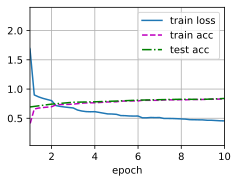

In [ ]:
import torch
import torch.nn as nn


net28 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1),

    nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(128, 96, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(96 * 5 * 5, 2048), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024), nn.ReLU(),
    nn.Dropout(p=0.5),

    nn.Linear(1024, 10)
)

batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
lr, num_epochs = 0.01, 10
d2l.train_ch6(net28, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 7.1.3

修改批量大小，并观察模型精度和GPU显存变化。

**解答：**

&emsp;&emsp;分别对比batch_size为64，128，512时的模型精度和GPU显存变化。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

AlexNet = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

&emsp;&emsp;batch_size=64，显存占用为：3.74GB，模型精度：loss 0.274, train acc 0.898, test acc 0.895

loss 0.274, train acc 0.898, test acc 0.895
1340.3 examples/sec on cuda:0


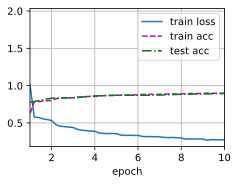

In [ ]:
batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;batch_size=128，显存占用为：7.93GB，模型精度：loss 0.324, train acc 0.880, test acc 0.886

loss 0.324, train acc 0.880, test acc 0.886
1627.7 examples/sec on cuda:0


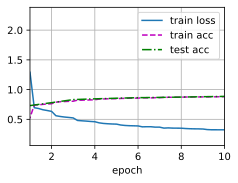

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;batch_size=512，显存占用为：7.93GB，模型精度：loss 0.504, train acc 0.811, test acc 0.823

loss 0.504, train acc 0.811, test acc 0.823
1439.9 examples/sec on cuda:0


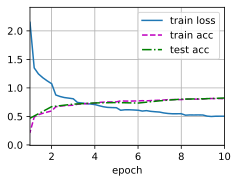

In [ ]:
batch_size = 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
lr, num_epochs = 0.01, 10
d2l.train_ch6(AlexNet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;在上面的实验中可以看出，batch_size越大运行所需要的显存就越多，模型的精度也会降低。

### 练习 7.1.4

分析AlexNet的计算性能。
1. 在AlexNet中主要是哪部分占用显存？
1. 在AlexNet中主要是哪部分需要更多的计算？
1. 计算结果时显存带宽如何？

**解答：**

**问题1**

&emsp;&emsp;在AlexNet中，占据最多显存的层是第一层卷积层和第二层卷积层。这是因为卷积层需要存储卷积核参数和中间计算结果，而且随着层数的增加，卷积层的输出通道数也会逐步增加，导致占用的显存也随之增加。相比之下，池化层和ReLU激活函数层等计算量较小的层，占用的显存相对较少。全连接层的显存占用量也较大，但是整个模型中只有两层全连接层，因此相对于卷积层而言，对显存的占用不是很明显。

**问题2**

&emsp;&emsp;在这个模型中，需要更多计算的层主要是全连接层。全连接层的计算量与输入和输出的维度相关，因此输入维度为6400的第一层全连接层和输出维度为4096的第二层全连接层需要更多的计算。这两个全连接层的计算量是其他卷积层的数倍，也是整个模型计算量的瓶颈。因此，在实际应用中，可以考虑减少全连接层的数量和神经元个数，以减少计算量并提高模型的运行速度。

**问题3**

&emsp;&emsp;（不是很理解）

### 练习 7.1.5

将dropout和ReLU应用于LeNet-5，效果有提升吗？再试试预处理会怎么样？

**解答：**

&emsp;&emsp;先看看看第六章原版LeNet的表现。

loss 0.465, train acc 0.826, test acc 0.788
35705.9 examples/sec on cuda:0


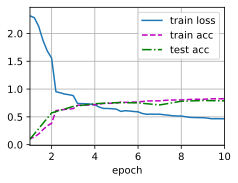

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;加入dropout和relu，并调节超参数。

loss 0.508, train acc 0.815, test acc 0.841
33729.1 examples/sec on cuda:0


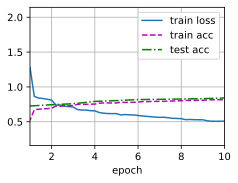

In [ ]:
LeNet_plus = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(84, 10))

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.12, 10
d2l.train_ch6(LeNet_plus, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;将dropout和ReLU应用于LeNet之后会提升其性能：

- Dropout可以防止过拟合，避免神经元之间的过度共适应，从而提高网络的泛化能力。可以看出在加入Dropout之后，test_acc相比原版网络有所提升，说明网络的泛化能力得到了提高。

- ReLU可以增加网络的非线性，从而提高其表示能力。用relu替代sigmoid之后，需要把模型的学习率调低，模型可以更加快速的收敛。

## 7.2 使用块的网络（VGG）

### 练习 7.2.1

打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？

**解答：**

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


&emsp;&emsp;这里的输出是13行，但是本质上输出的是8层神经网络。其中Sequential5层，其中Linear3层，ReLU，Dropout这些层都不算的，因为它们不是神经元。

&emsp;&emsp;原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

&emsp;&emsp;我们可以得知前两个Sequential层包含了1个卷积层，后三个Sequential层包含了两个卷积层。可以使用如下代码打印网络结构：

In [ ]:
X = torch.randn(size=(1, 1, 224, 224))

def print_net(net):
    global X
    for blk in net:
        if blk.__class__.__name__ == "Sequential":
            print_net(blk)
            print()
        else:
            X = blk(X)
            print(blk.__class__.__name__,'output shape:\t',X.shape)

print_net(net)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 512, 14, 14])

Conv2d output shape:	 torch.Size([1, 512, 14, 14])
ReLU output shape:	 torch.Size([1, 512, 14, 14])
Conv2d output shape:	 torch.Size([1, 512, 14, 14])
ReLU output shape:	 to

### 练习 7.2.2

与AlexNet相比，VGG的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。

**解答：**

&emsp;&emsp;1. 更深的网络结构：VGG相比于AlexNet增加了网络层数，采用了16-19层的卷积层，这导致了计算量的增加和显存的需求增加。

&emsp;&emsp;2. 更小的卷积核：VGG网络中采用了较小的3x3卷积核，相比AlexNet的7x7卷积核，这样做的好处是可以增加网络的深度，但是却会导致计算量和显存的需求增加。因为采用了小卷积核，需要进行更多的卷积操作，这增加了计算量；同时，每个卷积核的参数数量更多，需要更多的显存进行存储，增加了显存需求。 因此，VGG相比于AlexNet具有更深的网络结构和更小的卷积核，这使得它需要更多的计算和显存。



### 练习 7.2.3

尝试将Fashion-MNIST数据集图像的高度和宽度从224改为96。这对实验有什么影响？

**解答：**

&emsp;&emsp;由于VGG-11比AlexNet计算量更大，因此我们使用书上构建的一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。

&emsp;&emsp;如下是不修改数据集的高度和宽度。

loss 0.181, train acc 0.933, test acc 0.921
1143.1 examples/sec on cuda:0


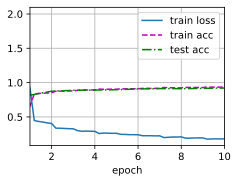

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;参数保持不变，(其中线性层的神经元数量需要稍作修改)修改图像高度和宽度为96.

loss 0.214, train acc 0.920, test acc 0.910
4760.4 examples/sec on cuda:0


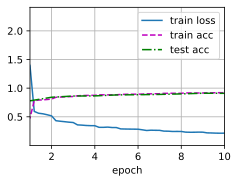

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(1152, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

1. 准确率下降：由于VGG网络是在ImageNet数据集上进行训练的，其输入图像大小为224x224。将输入图像大小从224x224改为96x96，会导致图像信息的丢失，从而影响网络的准确率。

2. 训练时间缩短：由于输入图像大小变小，计算量也相应减小，这会使得模型的训练时间缩短。

3. 内存占用减少：由于输入图像大小变小，模型参数数量也会减少，这将使得模型所需要的内存占用减少。

&emsp;&emsp;综上所述，将Fashion-MNIST数据集图像的高度和宽度从224改为96，可能会导致模型准确率下降，但同时也会缩短训练时间，减少内存占用。因此，需要根据具体的应用场景和需求来选择合适的输入图像大小。



### 练习 7.2.4

请参考VGG论文中的表1构建其他常见模型，如VGG-16或VGG-19。

**解答：**

&emsp;&emsp;参考文献：https://arxiv.org/pdf/1409.1556.pdf, 以下为VGG16模型和vgg19模型。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
net16 = vgg(conv_arch)

In [ ]:
X = torch.randn(size=(1, 1, 224, 224))
def print_net(net):
    global X
    for blk in net:
        if blk.__class__.__name__ == "Sequential":
            print_net(blk)
            print()
        else:
            X = blk(X)
            print(blk.__class__.__name__,'output shape:\t',X.shape)
print_net(net16)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 torch.Size([1, 512, 28, 28])
ReLU output shape:	 torch.Size([1, 512, 28, 28])
Conv2d output shape:	 

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))
net19 = vgg(conv_arch)

In [ ]:
X = torch.randn(size=(1, 1, 224, 224))
def print_net(net):
    global X
    for blk in net:
        if blk.__class__.__name__ == "Sequential":
            print_net(blk)
            print()
        else:
            X = blk(X)
            print(blk.__class__.__name__,'output shape:\t',X.shape)
print_net(net19)

Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 224, 224])
ReLU output shape:	 torch.Size([1, 64, 224, 224])
MaxPool2d output shape:	 torch.Size([1, 64, 112, 112])

Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
Conv2d output shape:	 torch.Size([1, 128, 112, 112])
ReLU output shape:	 torch.Size([1, 128, 112, 112])
MaxPool2d output shape:	 torch.Size([1, 128, 56, 56])

Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
Conv2d output shape:	 torch.Size([1, 256, 56, 56])
ReLU output shape:	 torch.Size([1, 256, 56, 56])
MaxPool2d output shape:	 torch.Size([1, 256, 28, 28])

Conv2d output shape:	 

## 7.3 网络中的网络（NiN）

### 练习 7.3.1

调整NiN的超参数，以提高分类准确性。

**解答：**

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [ ]:
hyper_0 = [0.1, 10, 128]
hyper_1 = [0.08, 10, 128]
hyper_2 = [0.1, 10, 64]
hyper_3 = [0.1,10, 512]
hyper_4 = [0.2, 10, 128]
hyper_params = [hyper_0, hyper_1, hyper_2, hyper_3, hyper_4]

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    # print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    # animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
    #                         legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            #     animator.add(epoch + (i + 1) / num_batches,
            #                  (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch + 1, (None, None, test_acc))
    # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
    #       f'test acc {test_acc:.3f}')
    # print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
    #       f'on {str(device)}')
    return [train_l, train_acc, test_acc]

In [ ]:
for hyper in hyper_params:
    lr, num_epochs, batch_size = hyper[0], hyper[1], hyper[2]
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
    res = train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
    print(f"lr: {hyper[0]}, num_epochs: {hyper[1]}, batch_size: {hyper[2]}\n\t loss {res[0]:.3f}, train acc {res[1]:.3f},test acc {res[2]:.3f}")

lr: 0.1, num_epochs: 10, batch_size: 128
	 loss 0.770, train acc 0.721,test acc 0.724
lr: 0.08, num_epochs: 10, batch_size: 128
	 loss 0.982, train acc 0.592,test acc 0.577
lr: 0.1, num_epochs: 10, batch_size: 64
	 loss 0.251, train acc 0.908,test acc 0.905
lr: 0.1, num_epochs: 10, batch_size: 512
	 loss 0.915, train acc 0.667,test acc 0.661
lr: 0.2, num_epochs: 10, batch_size: 128
	 loss 0.293, train acc 0.892,test acc 0.897


&emsp;&emsp;可以看出在这组“lr: 0.1, num_epochs: 10, batch_size: 64”参数下模型的精度最高。

### 练习 7.3.2

为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。

**解答：**

&emsp;&emsp;先来看两层$1\times1$卷积层的效果

loss 0.325, train acc 0.879, test acc 0.872
1431.5 examples/sec on cuda:0


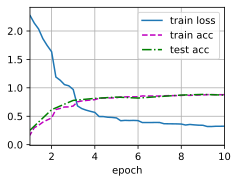

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;删掉一层$1\times1$卷积层的效果

loss 1.118, train acc 0.567, test acc 0.553
1648.7 examples/sec on cuda:0


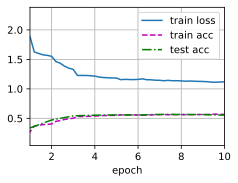

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;$1\times1$卷积层在NiN模型中起到了重要作用。它们可以增加网络的非线性能力，同时保持感受野的大小不变。还可以用于减少特征图的数量，从而减少计算量。删除一个$1\times1$卷积层会影响模型的精度，因为它会减少模型的非线性能力和特征提取能力。

### 练习 7.3.3

计算NiN的资源使用情况。
1. 参数的数量是多少？
1. 计算量是多少？
1. 训练期间需要多少显存？
1. 预测期间需要多少显存？

**解答：**

**问题1**

&emsp;&emsp;参数量计算方法：$kernel \times kernel \times channel_{input} \times channel_{output}$

&emsp;&emsp;对于每个卷积层，参数数量为输入通道数乘以卷积核尺寸乘以输出通道数，加上输出通道数作为偏置项的数量。

&emsp;&emsp;第一个nin_block的参数数量为$11 \times 11 \times 3 \times 96+1 \times 1 \times 96 \times 96+1 \times 1 \times 96 \times 96=53280$

&emsp;&emsp;第二个nin_block的参数数量为$5 \times 5 \times 96 \times 256+1 \times 1 \times 256 \times 256+1 \times 1 \times 256 \times 256=745472$

&emsp;&emsp;第三个nin_block的参数数量为$3 \times 3 \times 256 \times 384+1 \times 1 \times 384 \times 384+1 \times 1 \times 384 \times 384=1179648$

&emsp;&emsp;最后一个nin_block的参数数量为$3 \times 3 \times 384 \times 10+1 \times 1 \times 10 \times 10+1 \times 1 \times 10 \times 10=34760$

&emsp;&emsp;模型的总参数数量为$53280+745472+1179648+34760=2013160$

**问题2**

&emsp;&emsp;计算量计算方法：$kernel\times kernel \times map \times map \times channel_{input} \times channel_{output}$

&emsp;&emsp;所以计算量等于  $ (当前层的参数量) \times map \times map$，即总计算量为$53280 \times 54 \times 54+745472 \times 27 \times 27+1179648 \times 13 \times 13+34760 \times 1 \times 1=898208840≈8.9 \times 10^8$

**问题3**

&emsp;&emsp;显存里包含的内容有：参数的权重，参数的梯度，以及梯度反向传播过程中的中间值，最后还有数据（batch_size）.所以根据每个人所使用的参数不同，显卡型号不同，显存大小也会有不同。所以这个需要亲自尝试。

**问题4**

&emsp;&emsp;问题同上。

### 练习 7.3.4

一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？

**解答：**

&emsp;&emsp;在最后一层中，一次性直接将$384×5×5$的表示缩减为$10×5×5$的表示，可能会导致信息丢失。这是因为在这一层中，输出通道的数量从384减少到了10，这意味着模型必须在这一层中丢弃大量的信息。这可能会影响模型的性能。

&emsp;&emsp;这种设计也有其优点。它可以减少模型所需的参数数量，从而减少过拟合的风险，并加快模型的训练速度。因此，在实际应用中，需要在保留足够信息和减少模型复杂度之间取得平衡。

## 7.4 含并行链接的网络（GoogleLeNet）

### 练习 7.4.1

GoogLeNet有一些后续版本。尝试实现并运行它们，然后观察实验结果。这些后续版本包括：
1. 添加批量规范化层 （batch normalization），（在7.5节中将介绍）；
1. 对Inception模块进行调整；
1. 使用标签平滑（label smoothing）进行模型正则化；
1. 加入残差连接（将在7.6节中介绍）。

**解答：**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


**问题1**

In [ ]:
class BNInception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(BNInception, self).__init__(**kwargs)
        self.p1_1 = nn.Sequential(nn.Conv2d(in_channels, c1, kernel_size=1),
                      nn.BatchNorm2d(c1))
        self.p2_1 = nn.Sequential(nn.Conv2d(in_channels, c2[0], kernel_size=1),
                      nn.BatchNorm2d(c2[0]))
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1),
                      nn.BatchNorm2d(c2[1]))
        self.p3_1 = nn.Sequential(nn.Conv2d(in_channels, c3[0], kernel_size=1),
                      nn.BatchNorm2d(c3[0]))
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2),
                      nn.BatchNorm2d(c3[1]))
        self.p4_1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                      nn.BatchNorm2d(in_channels))
        self.p4_2 = nn.Sequential(nn.Conv2d(in_channels, c4, kernel_size=1),
                      nn.BatchNorm2d(c4))

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(BNInception(192, 64, (96, 128), (16, 32), 32),
                   BNInception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(BNInception(480, 192, (96, 208), (16, 48), 64),
                   BNInception(512, 160, (112, 224), (24, 64), 64),
                   BNInception(512, 128, (128, 256), (24, 64), 64),
                   BNInception(512, 112, (144, 288), (32, 64), 64),
                   BNInception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(BNInception(832, 256, (160, 320), (32, 128), 128),
                   BNInception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


**问题2**

In [ ]:
class AdInception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super().__init__(*kwargs)
        self.p1 = nn.Sequential(nn.LazyConv2d(c1, kernel_size=1),
                                nn.ReLU())
        self.p2 = nn.Sequential(nn.LazyConv2d(c2[0], kernel_size=1),
                                nn.ReLU())
        self.p2_1 = nn.Sequential(nn.LazyConv2d(c2[1], kernel_size=(1,3), padding=(0,1)),
                                nn.ReLU())
        self.p2_2 = nn.Sequential(nn.LazyConv2d(c2[2], kernel_size=(3,1), padding=(1,0)),
                                nn.ReLU())
        self.p3 = nn.Sequential(nn.LazyConv2d(c3[0], kernel_size=1),
                                nn.ReLU(),
                                nn.LazyConv2d(c3[1], kernel_size=3, padding=1),
                                nn.ReLU())
        self.p3_1 = nn.Sequential(nn.LazyConv2d(c3[2], kernel_size=(1,3), padding=(0,1)),
                                nn.ReLU())
        self.p3_2 = nn.Sequential(nn.LazyConv2d(c3[3], kernel_size=(3,1), padding=(1,0)),
                                nn.ReLU())
        self.p4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                nn.LazyConv2d(c4, kernel_size=1),
                                nn.ReLU())

    def forward(self, x):
        p1 = self.b1(x)
        p2 = self.b2(x)
        p2_1 = self.b2_1(p2)
        p2_2 = self.b2_2(p2)
        p3 = self.b3(x)
        p3_1 = self.b3_1(p3)
        p3_2 = self.b3_2(p2)
        p4 = self.b4(x)
        return torch.cat((p1,p2_1,p2_2,p3_1,p3_2,p4),dim=1)

In [ ]:
class AdInception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(AdInception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=(1,3), padding=(0,1))
        self.p2_3 = nn.Conv2d(c2[1], c2[2], kernel_size=(3,1), padding=(1,0))
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=3, padding=1)
        self.p3_3 = nn.Conv2d(c3[1], c3[2], kernel_size=(1,3), padding=(0,1))
        self.p3_4 = nn.Conv2d(c3[2], c3[3], kernel_size=(3,1), padding=(1,0))
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_3(F.relu(self.p2_2(F.relu(self.p2_1(x))))))
        p3 = F.relu(self.p3_4(F.relu(self.p3_3(F.relu(self.p3_2(F.relu(self.p3_1(x))))))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(AdInception(192, 64, (96, 112, 128), (16, 24, 28, 32), 32),
                   AdInception(256, 128, (128, 160, 192), (32, 48, 64, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(AdInception(480, 192, (96, 144, 208), (16, 24, 36, 48), 64),
                   AdInception(512, 160, (112, 168, 224), (24, 36, 48, 64), 64),
                   AdInception(512, 128, (128, 192, 256), (24, 36, 48, 64), 64),
                   AdInception(512, 112, (144, 216, 288), (32, 40, 48, 64), 64),
                   AdInception(528, 256, (160, 240, 320), (32, 64, 96, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(AdInception(832, 256, (160, 240, 320), (32, 64, 96, 128), 128),
                   AdInception(832, 384, (192, 288, 384), (48, 64, 96, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


**问题3**

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(1)
        log_preds = F.log_softmax(preds, dim=1)
        loss = -log_preds.sum(dim=1)
        nll = F.nll_loss(log_preds, target, reduction='none')
        loss = (1.0 - self.epsilon) * nll + self.epsilon * loss / n_classes
        return loss.mean()

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
criterion = LabelSmoothingCrossEntropy(epsilon=0.1)
optimizer = torch.optim.Adam(net.parameters())

optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

**问题4**

In [ ]:
class ResInception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x)) + x
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x)))) + x
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x)))) + x
        p4 = F.relu(self.p4_2(self.p4_1(x))) + x
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 练习 7.4.2

使用GoogLeNet的最小图像大小是多少？

**解答：**

&emsp;&emsp;224 * 224

### 练习 7.4.3

将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？

**解答：**

&emsp;&emsp;NiN采用了全局平均池化，可以将卷积层的输出直接平均成一个数，从而减少了全连接层的参数数量。NiN还采用了1x1卷积，可以在不改变特征图大小的情况下改变特征图的深度，从而进一步减少了模型参数数量。

&emsp;&emsp;GoogLeNet使用了Inception块，可以通过并联的方式将不同的卷积层结合在一起，从而减少模型参数大小。



## 7.5 批量规范化

### 练习 7.5.1

在使用批量规范化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？

**解答：**

&emsp;&emsp;可以。`BatchNorm`的作用是对每个batch的数据进行规范化，使得每个batch的数据分布相同，从而加速模型训练。因此，`BatchNorm`可以替代全连接层或卷积层中的偏置参数，因为它可以自动地学习偏置参数。



### 练习 7.5.2

比较LeNet在使用和不使用批量规范化情况下的学习率。
1. 绘制训练和测试准确度的提高。
1. 学习率有多高？

**解答：**

&emsp;&emsp; 学习率保持一致，都取$0.9$

&emsp;&emsp;先来看不使用批量规范化的效果

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10))

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 13650049.87it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201714.95it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3793782.62it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6611229.94it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss 0.475, train acc 0.820, test acc 0.789
37363.8 examples/sec on cuda:0


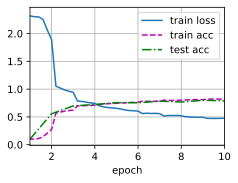

In [ ]:
lr, num_epochs = 0.9, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

&emsp;&emsp;再来看使用批量规范化的效果

In [ ]:
bn_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(6),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.BatchNorm2d(16),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(16),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.240, train acc 0.912, test acc 0.887
27995.2 examples/sec on cuda:0


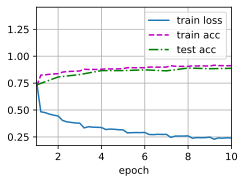

In [ ]:
d2l.train_ch6(bn_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 7.5.3

我们是否需要在每个层中进行批量规范化？尝试一下？

**解答：**

&emsp;&emsp; 一般来说，`BatchNorm`可以在卷积层和全连接层之间使用，也可以在激活函数之前或之后使用。但是，并不是所有的层都需要使用`BatchNorm`，有时候使用过多的BatchNorm反而会降低模型性能。


In [ ]:
all_bn_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.BatchNorm2d(6),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(6),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.BatchNorm2d(16),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(16),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.BatchNorm1d(120),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.BatchNorm1d(84),
    nn.Linear(84, 10),
    nn.BatchNorm1d(10))

loss 0.237, train acc 0.913, test acc 0.867
21976.4 examples/sec on cuda:0


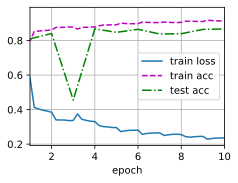

In [ ]:
d2l.train_ch6(all_bn_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 7.5.4

可以通过批量规范化来替换暂退法吗？行为会如何改变？

**解答：**

&emsp;&emsp; 可以，但一般是直接进行替换，不会同时用，因为二者都是起到正则项的作用

### 练习 7.5.5

确定参数`beta`和`gamma`，并观察和分析结果。

**解答：**

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
BN_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(6),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.BatchNorm2d(16),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(16),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.249, train acc 0.907, test acc 0.879
23309.5 examples/sec on cuda:0


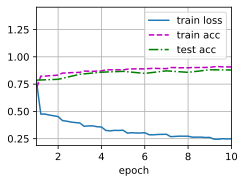

In [ ]:
d2l.train_ch6(BN_net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
BN_net[1].gamma.reshape((-1,)), BN_net[1].beta.reshape((-1,))

(tensor([2.4953, 1.3921, 3.0666, 2.4469, 1.5620, 2.0602], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 1.0328,  1.2517, -0.4663,  2.0004, -1.4250, -2.1138], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

### 练习 7.5.6

查看高级API中有关`BatchNorm`的在线文档，以查看其他批量规范化的应用。

**解答：**

&emsp;&emsp; [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html?highlight=batchnorm#torch.nn.BatchNorm1d)

&emsp;&emsp; [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)

&emsp;&emsp; [BatchNorm3d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm3d.html?highlight=batchnorm#torch.nn.BatchNorm3d)

&emsp;&emsp; [LazyBatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm1d.html?highlight=batchnorm#torch.nn.LazyBatchNorm1d)

&emsp;&emsp; [LazyBatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm2d.html?highlight=batchnorm#torch.nn.LazyBatchNorm2d)

&emsp;&emsp; [LazyBatchNorm3d](https://pytorch.org/docs/stable/generated/torch.nn.LazyBatchNorm3d.html?highlight=batchnorm#torch.nn.LazyBatchNorm3d)



### 练习 7.5.7

研究思路：可以应用的其他“规范化”转换？可以应用概率积分变换吗？全秩协方差估计可以么？

**解答：**

&emsp;&emsp; 除了BatchNorm，还有以下一些常用的规范化技术：

&emsp;&emsp; 1. `LayerNorm`: 对单个样本的所有神经元进行规范化，而不是BatchNorm中的样本批次。对于RNN特别有用。

&emsp;&emsp; 2. `InstanceNorm`: 主要用于样式转换任务。

&emsp;&emsp; 3. `GroupNorm`: 把通道分为几个组，并对每一组进行规范化。

&emsp;&emsp; 以上方法的核心思想是进行归一化操作，以确保输入值的分布在经过激活函数之前保持相对稳定。

&emsp;&emsp; 概率积分变换：它是一种将任意分布转换为均匀分布的方法。虽然它在统计学中被广泛使用，但在深度学习中不太常见，主要是因为它通常需要知道数据的分布或者需要一个非参数方法来估计这个变换，这在神经网络任务中可能是不实际的。

&emsp;&emsp; 全秩协方差估计：在深度学习中直接使用全秩协方差估计进行规范化是不常见的，主要是因为计算和存储开销可能非常大，特别是对于神经网络。但是，有些方法可能会利用协方差的某些性质或简化版本。例如，`Whitening`操作就是基于协方差矩阵的。


## 7.6 残差网络（ResNet）

In [ ]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.015, train acc 0.996, test acc 0.919
1585.4 examples/sec on cuda:0


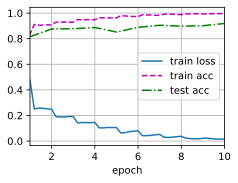

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习 7.6.1

图7-5中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？

**解答：**

&emsp;&emsp; 它们的主要区别在于，Inception块是由多个不同大小的卷积核组成的，可以在同一层上获得稀疏或非稀疏的特征；而残差块则是通过添加跨层连接来解决深度神经网络中的梯度消失问题。

&emsp;&emsp; 当删除了Inception块中的一些路径之后，它们之间的关系会发生变化，因为这些路径是相互关联的。

### 练习 7.6.2

参考ResNet论文中的表1，以实现不同的变体。

**解答：**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

def make_layer(block, in_channels, out_channels, blocks, stride=1):
    downsample = None
    if stride != 1 or in_channels != out_channels * block.expansion:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels * block.expansion)
        )

    layers = []
    layers.append(block(in_channels, out_channels, stride, downsample))
    in_channels = out_channels * block.expansion
    for _ in range(1, blocks):
        layers.append(block(in_channels, out_channels))

    return nn.Sequential(*layers)

def resnet(arch):
    block, layers = {
        'resnet18': (BasicBlock, [2, 2, 2, 2]),
        'resnet34': (BasicBlock, [3, 4, 6, 3]),
        'resnet50': (Bottleneck, [3, 4, 6, 3]),
    }[arch]

    b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                       nn.BatchNorm2d(64), nn.ReLU(),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    b2 = make_layer(block, 64, 64, layers[0])
    b3 = make_layer(block, 64 * block.expansion, 128, layers[1], stride=2)
    b4 = make_layer(block, 128 * block.expansion, 256, layers[2], stride=2)
    b5 = make_layer(block, 256 * block.expansion, 512, layers[3], stride=2)

    net = nn.Sequential(b1, b2, b3, b4, b5,
                        nn.AdaptiveAvgPool2d((1, 1)),
                        nn.Flatten(), nn.Linear(512 * block.expansion, 10))

    return net

net = resnet('resnet50')

In [ ]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=

### 练习 7.6.3

对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。

**解答：**

&emsp;&emsp; 在一题中已经完成定义

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

### 练习 7.6.4

在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见参考文献[57]中的图1。

**解答：**

In [ ]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = self.conv1(F.relu(self.bn1(X)))
        Y = self.conv2(F.relu(self.bn2(Y)))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return Y

### 练习 7.6.5

为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？

**解答：**

&emsp;&emsp; 因为过于复杂的函数会导致过拟合，从而降低模型的泛化能力。

## 7.7 稠密连接网络（DenseNet）

In [6]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [7]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
              lr=0.1, num_classes=10):
        super(DenseNet, self).__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
              num_channels //= 2
              self.net.add_module(f'tran_blk{i+1}', transition_block(
                  num_channels))
        self.net.add_module('last', nn.Sequential(
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
        self.net.apply(d2l.init_cnn)

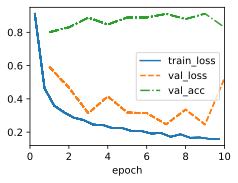

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

### 练习 7.7.1

为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？

**解答：**

&emsp;&emsp; 因为平均汇聚层可以更好地保留特征图中的信息，而最大汇聚层会丢失一些信息。

### 练习 7.7.2

DenseNet的优点之一是其模型参数比ResNet小。为什么呢？

**解答：**

&emsp;&emsp; 因为DenseNet中每个卷积层的输入都是前面所有层的输出的拼接，而不是像ResNet一样只是前面一层的输出。这种设计使得DenseNet中每个卷积层的输入通道数比ResNet少很多，因此DenseNet中的BN层参数也会少很多，全连接层的参数也比ResNet少很多。

### 练习 7.7.3

DenseNet一个诟病的问题是内存或显存消耗过多。
1. 真的是这样吗？可以把输入形状换成$224 \times 224$，来看看实际的显存消耗。
2. 有另一种方法来减少显存消耗吗？需要改变框架么？

**解答：**

**问题1**

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

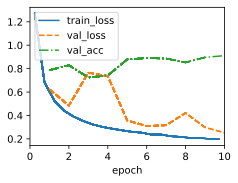

In [9]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
model = DenseNet(lr=0.01)
trainer_224 = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer_224.fit(model, data)
memory_stats = torch.cuda.memory_stats(device='cuda')

In [13]:
print("显存消耗为", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("内存消耗为", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

显存消耗为 4158.44775390625 MB
内存消耗为 46.6328125 MB


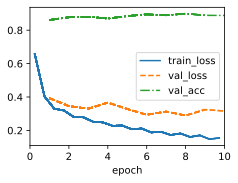

In [16]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
model = DenseNet(lr=0.01)
trainer_32 = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(32, 32))
trainer_32.fit(model, data)
memory_stats = torch.cuda.memory_stats(device='cuda')

In [17]:
print("显存消耗为", memory_stats["allocated_bytes.all.peak"] / (1024 ** 2), "MB")
print("内存消耗为", memory_stats["allocated_bytes.all.current"] / (1024 ** 2), "MB")

显存消耗为 318.5234375 MB
内存消耗为 74.71142578125 MB


**问题2**

**解答：**

&emsp;&emsp; 除了减小输入张量的大小，以下策略也可能有助于减少网络的显存消耗：

&emsp;&emsp; 1. 减少网络复杂性：可通过减小DenseNet网络中层的数量，或者减小每层中的神经元数量来实现。例如，您可以选择小一些的DenseNet结构（如DenseNet121），或者自定义一个更小的DenseNet。但是请注意，这样做可能会影响网络的性能。

&emsp;&emsp; 2. 采用模型压缩技术：模型压缩技术如权重量化、知识蒸馏等可以有效地减少网络对显存的需求，且通常能保持原始网络的性能。

&emsp;&emsp; 3. 改变优化器：一些优化器例如Adam，由于存储了大量的梯度信息，可能会导致显存使用增加。使用像SGD这样的优化器可能对显存需求更小。

&emsp;&emsp; 4. 混合精度训练：混合精度训练是一种在训练过程中同时使用float32和float16数据类型的方法，能够有效节省显存消耗，同时一般不会对模型精度产生太大影响。需要注意的是，硬件必须支持float16运算。

&emsp;&emsp; 5. 梯度累积：在PyTorch等框架中，可以利用梯度累积技术减小batch size，每次前向传播计算得到梯度后并不立即更新参数，而是累积几次梯度后再更新，这样可以在不损失模型性能的情况下有效降低显存占用。

&emsp;&emsp; 通常情况下，无需因此改变框架。

### 练习 7.7.4

实现DenseNet论文[71]表1所示的不同DenseNet版本。

**解答：**

In [18]:
class DenseNet(nn.Module):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4), num_classes=10):
        super(DenseNet, self).__init__()

        self.b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.net = [self.b1]

        for i, num_convs in enumerate(arch):
            self.net.append(DenseBlock(num_convs, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.append(transition_block(num_channels))

        self.net.append(nn.Sequential(
            nn.BatchNorm2d(num_channels), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(num_channels, num_classes)))

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

def densenet(arch_name):
    arch_layers = {
        'densenet121': [6, 12, 24, 16],
        'densenet169': [6, 12, 32, 32],
        'densenet201': [6, 12, 48, 32],
    }
    return DenseNet(arch=arch_layers[arch_name])

# 使用示例
net = densenet('densenet121')
print(net)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


DenseNet(
  (b1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, tr

### 练习 7.7.5

应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于4.10节中的房价预测任务。

**解答：**

In [54]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [55]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [59]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
    def preprocess(self):
      # Remove the ID and label columns
      label = 'SalePrice'
      features = pd.concat(
          (self.raw_train.drop(columns=['Id', label]),
          self.raw_val.drop(columns=['Id'])))
      # Standardize numerical columns
      numeric_features = features.dtypes[features.dtypes!='object'].index
      features[numeric_features] = features[numeric_features].apply(
          lambda x: (x - x.mean()) / (x.std()))
      # Replace NAN numerical features by 0
      features[numeric_features] = features[numeric_features].fillna(0)
      # Replace discrete features by one-hot encoding
      features = pd.get_dummies(features, dummy_na=True)
      # Save preprocessed features
      self.train = features[:self.raw_train.shape[0]].copy()
      self.train[label] = self.raw_train[label]
      self.val = features[self.raw_train.shape[0]:].copy()
    def get_dataloader(self, train):
      label = 'SalePrice'
      data = self.train if train else self.val
      if label not in data: return
      get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                        dtype=torch.float32)
      # Logarithm of prices
      tensors = (get_tensor(data.drop(columns=[label])),  # X
                torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
      return self.get_tensorloader(tensors, train)

In [60]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [61]:
data.preprocess()
data.train.shape

(1460, 331)

In [62]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [63]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functi

average validation log mse = 0.18293014466762542


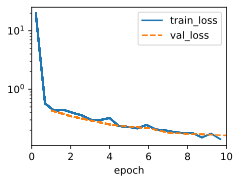

In [64]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [105]:
class HouseDenMLP(d2l.LinearRegression):
    def __init__(self, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.p0 = nn.Flatten()
        self.p1 = nn.Sequential(nn.LazyLinear(64),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p2 = nn.Sequential(nn.LazyLinear(32),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p3 = nn.Sequential(nn.LazyLinear(16),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.net = nn.Sequential(self.p1,
                    self.p2,
                    self.p3,
                    nn.LazyLinear(1))

    def forward(self, X):
        X = self.net[0](X)
        for blk in self.net[1:-1]:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return self.net[-1](X)

In [106]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = HouseDenMLP(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functi

average validation log mse = 0.2942724800109863


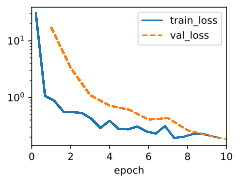

In [107]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)